In [ ]:

import numpy as np 
import cv2
import os
from os import listdir
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import hashlib


import plotly.graph_objs as go
from sklearn.utils import shuffle 




from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


from sklearn.model_selection import train_test_split



# Data Pre-processing and Data Augmentation

The process involves several steps

- class count analysis
- deleting duplicate images to help the model generalise better
- removing non-brain mri scans to ensure our model learns on correct information
- cropping out the brain region to speed up model training as well as decrease the weight enabling faster hypothesis testing
- augmenting the data to increase the size of the dataset and improve the model's performance and combat class imbalance
- resizing the images to reduce computational complexity and to maintain consistency

In [352]:
image_dir = 'brain_tumor_dataset/'

# Iterate directory
for type in ["no", "yes"]: 
    subdir_path = os.path.join(image_dir, type)
    count = 0
    for path in os.listdir(subdir_path):
        if os.path.isfile(os.path.join(subdir_path, path)):
            count += 1
    print(f"{type}: {count} images")

#As we can see our dataset is imbalanced with ratio of ~ 1:2 for negative:positive instances
#This suggests we should atleast double the amount of negative instances in comparison to positive 
#instances to balance the dataset to avoid bias in our model

no: 66 images
yes: 135 images


In [353]:

#Remove duplicate images from the dataset to avoid the model learning patterns instead of generalizing

def calculate_hash(image_path):
    #Calculate hash of an image 
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    image = cv2.resize(image, (224, 224))  # Resize for consistent hashing
    return hashlib.md5(image.tobytes()).hexdigest()  # Generate MD5 hash

def remove_duplicates(folder_path):
    #Remove duplicate images, print deleted filenames, and show matched images
    hashes = {}  # Dictionary to store unique image hashes
    duplicates = 0  # Counter for removed duplicates

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path):
            img_hash = calculate_hash(file_path)

            if img_hash in hashes:
                print(f"Removing: {filename} (Duplicate of: {hashes[img_hash]})")  # Show duplicate match
                os.remove(file_path)  # Delete the duplicate image
                duplicates += 1
            else:
                hashes[img_hash] = filename  # Store the first occurrence of the image

    print(f"\nTotal {duplicates} duplicate images removed from {folder_path}\n")


remove_duplicates("brain_tumor_dataset/no")
remove_duplicates("brain_tumor_dataset/yes")



Total 0 duplicate images removed from brain_tumor_dataset/no


Total 0 duplicate images removed from brain_tumor_dataset/yes



In [354]:
#Data inspection revealed that one file is an MRI of a spine, we need to remove it 

file_path_spine = 'brain_tumor_dataset/yes/Y248_SPINE.JPG'
if os.path.exists(file_path_spine):
    os.remove(file_path_spine)
    print(f"Deleted: {file_path_spine}")
else:
    print(f"File already deleted: {file_path_spine}")


File already deleted: brain_tumor_dataset/yes/Y248_SPINE.JPG


In [355]:
#Creating the directories for our augmented dataset

os.makedirs('dataset/augmented-images', exist_ok=True)
os.makedirs('dataset/augmented-images/yes', exist_ok=True)
os.makedirs('dataset/augmented-images/no', exist_ok=True)



In [356]:

#Crop the brain region from the image 
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
               
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

def crop_brain_region(image):
    """Crops the brain region from the image using contour detection."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        return image[y:y+h, x:x+w]
    
    return image

In [357]:
#Augment the data to increase the size of the dataset and improve the model's performance

def augment_data(file_dir, n_generated_samples, save_to_dir, label_prefix):

    data_gen = ImageDataGenerator(rotation_range=10, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                 )
    
    counter = 1
 

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = crop_brain_contour(image, False)
        # reshape the image
        image = image.reshape((1,)+image.shape)


        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_format='jpg'):
            save_path = os.path.join(save_to_dir, f"{label_prefix}{counter}.jpg")
            cv2.imwrite(save_path, batch[0])

            i += 1
            counter += 1

            if i > n_generated_samples:
                break

image_dir = 'brain_tumor_dataset/'
augmented_data_path ='dataset/augmented-images/'

augment_data(file_dir = image_dir + 'no', n_generated_samples = 8, save_to_dir = augmented_data_path + 'no', label_prefix = 'N')
augment_data(file_dir = image_dir + 'yes', n_generated_samples = 4, save_to_dir = augmented_data_path + 'yes', label_prefix = 'Y')


                

# Model Training and Evaluation

In [358]:
'''def plot_sample_images(X, y, n=10):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(X, y)'''

'def plot_sample_images(X, y, n=10):\n    for label in [0,1]:\n        # grab the first n images with the corresponding y values equal to label\n        images = X[np.argwhere(y == label)]\n        n_images = images[:n]\n        \n        columns_n = 10\n        rows_n = int(n/ columns_n)\n\n        plt.figure(figsize=(10, 8))\n        \n        i = 1 # current plot        \n        for image in n_images:\n            plt.subplot(rows_n, columns_n, i)\n            plt.imshow(image[0])\n            \n            # remove ticks\n            plt.tick_params(axis=\'both\', which=\'both\', \n                            top=False, bottom=False, left=False, right=False,\n                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)\n            \n            i += 1\n        \n        label_to_str = lambda label: "Yes" if label == 1 else "No"\n        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")\n        plt.show()\n\nplot_sample_images(X, y)'

In [359]:
#Load the dataset into numpy arrays for CNN comprehension

def load_data(dir_list):

    # load all images in a directory
    X = []
    y = []
    
    
    for directory in dir_list:
        for filename in listdir(directory):

            image = cv2.imread(directory + '/' + filename)
            image = cv2.resize(image, dsize=(256, 256), interpolation = cv2.INTER_CUBIC)

            # normalize values
            image = image / 255.
            X.append(image)

            # 1 for a positive instance, 0 for negative
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    #X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


augmented_yes = augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'

X, y = load_data([augmented_yes, augmented_no])

Number of examples is: 1269
X shape is: (1269, 256, 256, 3)
y shape is: (1269, 1)


In [360]:

# Split the dataset into 80% train, 10% validation, 10% test
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 1015 samples
Validation set: 127 samples
Test set: 127 samples


In [ ]:
#Define the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.2),

    Flatten(),  # Converts feature maps to 1D vector
    
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.4),  # Prevents overfitting
    
    Dense(1, activation='sigmoid')  # Final output layer (binary classification)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


#Train the model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[reduce_lr])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_147 (Conv2D)             │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 127, 127, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 62, 62, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 30, 30, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.5266 - loss: 0.7010 - val_accuracy: 0.5433 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 467ms/step - accuracy: 0.6314 - loss: 0.6512 - val_accuracy: 0.7717 - val_loss: 0.5852 - learning_rate: 1.0000e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 452ms/step - accuracy: 0.7332 - loss: 0.5689 - val_accuracy: 0.7402 - val_loss: 0.5297 - learning_rate: 1.0000e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.7737 - loss: 0.4877 - val_accuracy: 0.7402 - val_loss: 0.5220 - learning_rate: 1.0000e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.8213 - loss: 0.4027 - val_accuracy: 0.8189 - val_loss: 0.4526 - learning_rate: 1.0000e-04
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.8552 - loss: 0.3684 - val_accuracy: 0.8189 - val_loss: 0.4231 - learning_rate: 1.0000e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - acc

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9060 - loss: 0.4334
Test Accuracy: 91.34%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
              precision    recall  f1-score   support

    No Tumor       0.90      0.92      0.91        59
       Tumor       0.93      0.91      0.92        68

    accuracy                           0.91       127
   macro avg       0.91      0.91      0.91       127
weighted avg       0.91      0.91      0.91       127



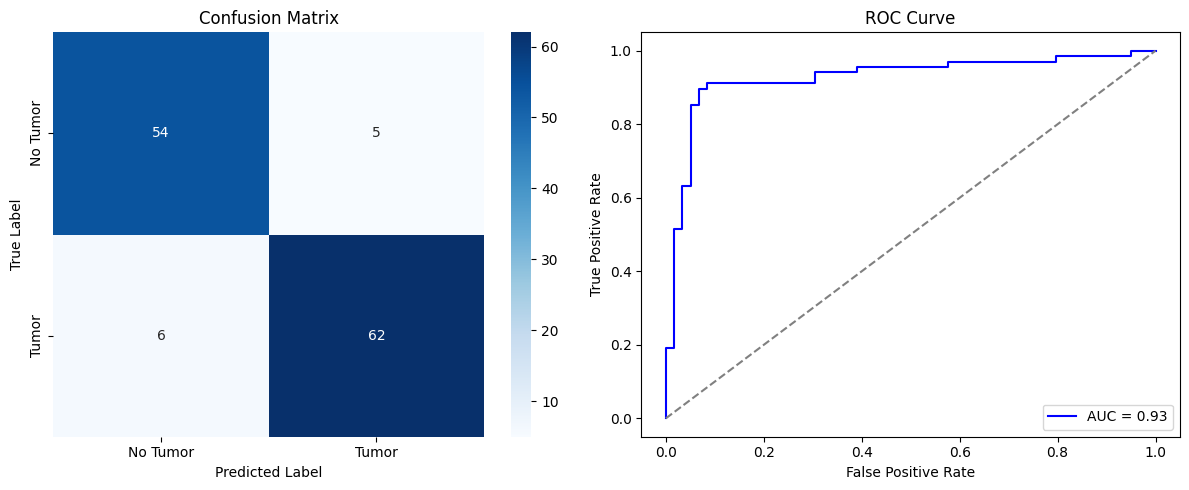

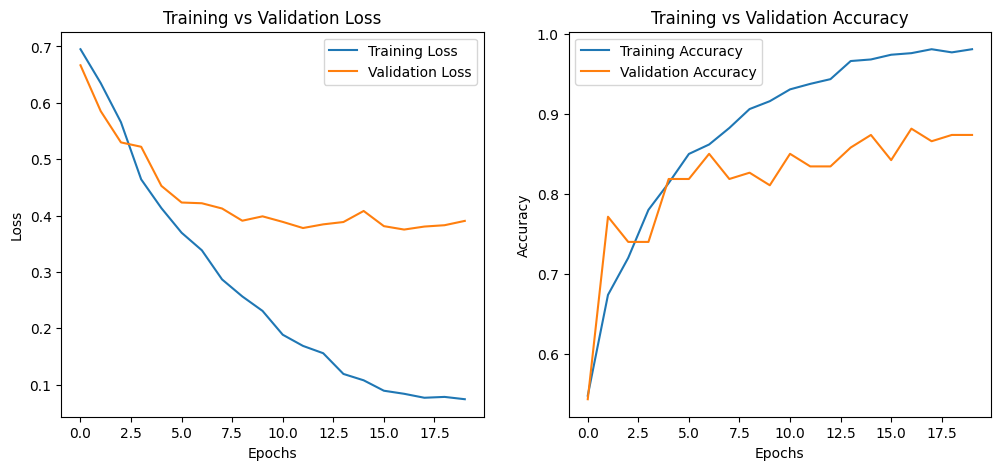

In [367]:
# Evaluate the model

# Evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_scores(X_test, y_test):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    # Predict labels for the test set
    y_prob = model.predict(X_test)  # Get predicted probabilities
    y_pred = (y_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

    # Print classification report
    print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"], ax=axes[0])
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_title("Confusion Matrix")

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Use y_prob for probability scores
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    axes[1].plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
    axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend(loc="lower right")

    # Show plots
    plt.tight_layout()
    plt.show()



def plot_loss(history):
    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    plt.show()

evaluate_scores(X_test, y_test)
plot_loss(history)

